In [1]:
include("prepare.jl")
include("L1AC.jl")

L1AC! (generic function with 2 methods)

In [2]:
total_steps = 80000

R0 = 10
β0 = - π / 2 * (3/4)
R_ref = R0
β_ref = - π / 2 * (3/4)
R_l1ac = R0

data = []

car = Car(state=State(x=-16., y=-11., ψ = 0., ẋ = 1., ẏ = 0., ψ̇ = 0.),tyre=Tyre(B=5, C=2, D=0.3))
β_controller = PID(Kp=4, Ki=0.001, Kd=60, sign=1)
R_controller = PID(Kp=30, Ki=0.001, Kd=5, sign=-1)
#R_controller = PID(Kp=100, Ki=0.8, Kd=100, sign=-1) 无前馈最佳参数
est = make_radius_estimator(10)
est_circles = []
β_refs = []
R_refs = []
l1ac = L1AC_Struct()

ω0 = 20
ω_ff = 0

est_circle = update!(est, car.state.x, car.state.y)

cx = 0.
cy = 0.
theta = - π
RR = 15
Cx = cx + RR * cos(theta)
Cy = cy + RR * sin(theta)
Cxs = []
Cys = []
error = 0
errors = []
texture = "snow"

for i in 1:total_steps

    if texture == "snow"
        β_ff, δ_ff = β_ff_snow, δ_ff_snow
        car.tyre = Tyre(B=5, C=2, D=0.3)
        ω_ff = 32.27746
    else
        β_ff, δ_ff = β_ff_ice, δ_ff_ice
        car.tyre = Tyre(B=4, C=2, D=0.15)
        ω_ff = 24.79148
    end

    if i % 1000 == 0
        theta += π / 36
        Cx = cx + RR * cos(theta)
        Cy = cy + RR * sin(theta)
    end

    est_circle = update!(est, car.state.x, car.state.y)
    R = est_circle.r
    
    s = car.state
    
    β = atan(s.ẏ, s.ẋ) - s.ψ
    err = round_angle(β - β_ref)
    δ = clamp(control!(β_controller, err), -π / 8, π / 8)
    
    if i % 10 == 0
        
        angle1 = atan(Cy - s.y, Cx - s.x)
        angle2 = atan(s.ẏ, s.ẋ)
        dangle = round_angle(angle1 - angle2)
        dis = sqrt((s.x - Cx) ^ 2 + (s.y - Cy) ^ 2)
        dR = R0 / 2 * tanh(dis) * cos(dangle)

        R_ref = R0 + dR
        if i > 100
            R_l1ac = L1AC!(l1ac, convert(Float64,R_ref), est_circle.r, 0.10)
            err = R - R_l1ac
            ω0 = clamp(ω_ff + control!(R_controller, err), 15, 45)
        else
            err = R - R_ref
            ω0 = clamp(ω_ff + control!(R_controller, err), 15, 45)
        end
    end
    ω = ω0
    # apply control and save data
    u = Input(δ, ω, ω)
    data_point = DriftData(s, u, compute_extended_state(s, u, car.body, car.tyre), R)
    step!(car, u, dt=0.01)
    
    if i < total_steps / 3
        texture = "snow"
    elseif i < total_steps * 2 / 3
        texture = "snow"
    else
        texture = "snow"
    end

    error = abs(sqrt((s.x - Cx)^2+(s.y - Cy)^2)-10)/10

    push!(data,  data_point)
    push!(β_refs, β_ref)
    push!(R_refs, R_ref)
    push!(est_circles, est_circle)
    push!(Cxs, Cx)
    push!(Cys, Cy)
    push!(errors, error)
end


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality co

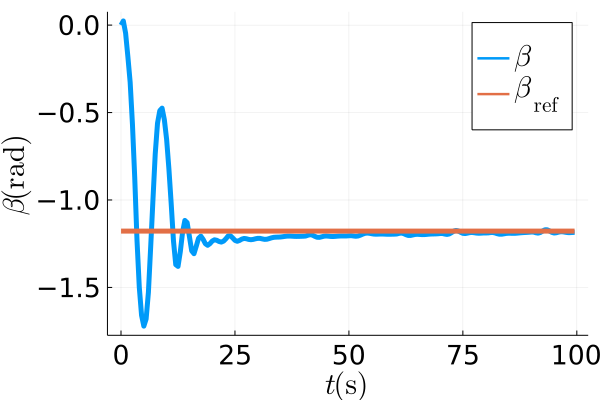

In [4]:
t1, t2 = 1, 10000
rate = 50
using Plots
using LaTeXStrings
using PGFPlotsX
gr()
p1 = plot(0.01*(t1:rate:t2),[p.es.β for p in data[t1:rate:t2]], label=L"$\beta$", xlabel=L"$t \mathrm{(s)}$",ylabel=L"$\beta \mathrm{(rad)}$", xtickfontsize=18,ytickfontsize=18,xguidefontsize=20,yguidefontsize=20,legendfontsize=20,width=5)
plot!(p1, 0.01*(t1:rate:t2),β_refs[t1:rate:t2], label=L"$\beta_{\mathrm{ref}}$",xtickfontsize=18,ytickfontsize=18,xguidefontsize=20,yguidefontsize=20,legendfontsize=20,width=5)
plot(p1)
#savefig(p1, "tikz/move-center/move-center-p1.pdf")
#savefig(p1, "tikz/move-center/move-center-p1.tikz")


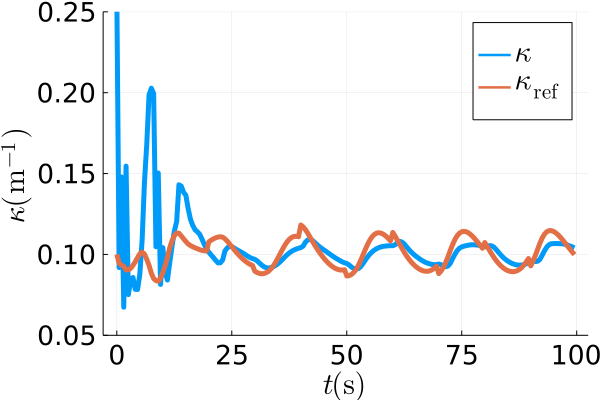

In [5]:
p2 = plot(0.01*(t1:rate:t2), [1/p.R for p in data[t1:rate:t2]], label=L"$\kappa$",xlabel=L"$t \mathrm{(s)}$", ylabel=L"$\kappa \mathrm{(m^{-1})}$",xtickfontsize=18,ytickfontsize=18,xguidefontsize=20,yguidefontsize=20,legendfontsize=18,width=5)
plot!(p2, 0.01*(t1:rate:t2),1 ./ R_refs[t1:rate:t2], label=L"$\kappa_{\mathrm{ref}}$",xtickfontsize=18,ytickfontsize=18,xguidefontsize=20,yguidefontsize=20,legendfontsize=20,width=5)
ylims!(p2,0.05,0.25)
plot(p2)
#savefig(p2, "tikz/move-center/move-center-p2.pdf")
#savefig(p2, "tikz/move-center/move-center-p2.tikz")


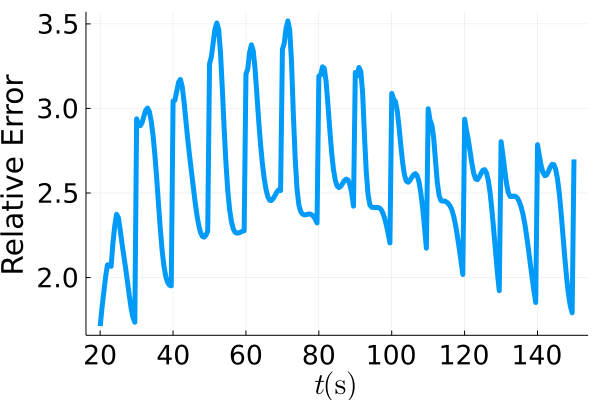

In [31]:
t1,t2 = 2001,15001
p4 = plot(0.01*(t1:rate:t2), [sqrt((Cxs[i]-est_circles[i].x0)^2+(Cys[i]-est_circles[i].y0)^2) for i in collect(t1:rate:t2)], label="",xlabel=L"$t \mathrm{(s)}$", ylabel="Relative Error",xtickfontsize=18,ytickfontsize=18,xguidefontsize=20,yguidefontsize=20,legendfontsize=20,width=5)
savefig(p4, "tikz/move-center/move-center-p4.pdf")
plot(p4)

In [32]:
t1, t2 = 2000, 80000
p3 = plot([p.s.x for p in data[t1:rate:t2]], [p.s.y for p in data[t1:rate:t2]], aspect_ratio=:equal, label="Drift Path", xlabel=L"$x \mathrm{(m)}$",ylabel=L"$y \mathrm{(m)}$",xtickfontsize=18,ytickfontsize=18,xguidefontsize=20,yguidefontsize=20,legendfontsize=12,width=3)
plot!(p3, [c.x0 for c in est_circles[t1:rate:t2]],[c.y0 for c in est_circles[t1:rate:t2]], label="Moving Center",xtickfontsize=18,ytickfontsize=18,xguidefontsize=20,yguidefontsize=20,legendfontsize=12,width=5,color=:purple)
lF, lR = car.body.lF, car.body.lR
plot(p3)
#savefig(p3, "tikz/move-center/move-center-p3.pdf")
#savefig(p3, "tikz/move-center/move-center-p3.tikz")